In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont
from utilities import *

# Question 1

In [ ]:
img = create_name('Hai', 'Name')
show_img(img, 'Name')

## 1B)

In [ ]:
# modify angle for different rotations
angle = 30
r_img = rotate(img, angle)
print(r_img.shape)
show_img(r_img, 'Rotated {}'.format(angle))
cv2.imwrite('figures/transformations/rotate{}.jpg'.format(angle), r_img)

In [ ]:
# modify angle for different skews
angle = 60
skewed_img = skew(img, angle)
print(skewed_img.shape)
show_img(skewed_img, 'Skewed')
cv2.imwrite('figures/transformations/skew{}.jpg'.format(angle), skewed_img)

## 1C)

In [ ]:
# rotate 20 then skew 50
new_img = rotate(img, 20)
new_img = skew(new_img, 50)
show_img(new_img, 'rotate20_skew50.jpg')
cv2.imwrite('figures/transformations/rotate20_skew50.jpg', new_img)

In [ ]:
# skew 50 then rotate 20
new_img = skew(img, 50)
new_img = rotate(new_img, 20)
show_img(new_img, 'skew50_rotate20.jpg')
cv2.imwrite('figures/transformations/skew50_rotate20.jpg', new_img)

# Question 2

In [ ]:
img = cv2.imread('Dataset/DatasetA/car-1.jpg')

## 2B)

In [ ]:
# kernel for computing average of neighbors
kernel_mean = np.array([
    [1, 1, 1],
    [1, 1, 1],
    [1, 1, 1]
])

kernel_mean = kernel_mean/kernel_mean.size

mean_img = apply_kernel(img, kernel_mean)
show_img(mean_img, 'Mean Filter')
cv2.imwrite('figures/convolutions/average_intensity.jpg', mean_img)

## 2C)

In [ ]:
# kernel A
kernel_A = np.array([
    [1, 2, 1],
    [2, 4, 2],    
    [1, 2, 1]
])

sum_A = np.sum(kernel_A)
kernel_A = kernel_A/sum_A

# kernel B
kernel_B = np.array([
    [0, 1, 0],
    [1, -4, 1],
    [0, 1, 0]
])

In [ ]:
# Kernel A
A_img = apply_kernel(img, kernel_A)
show_img(A_img, 'Kernel A')
cv2.imwrite('figures/convolutions/img_A.jpg', A_img)

In [ ]:
# Kernel B
B_img = apply_kernel(img, kernel_B)
show_img(B_img, 'Kernel B')
cv2.imwrite('figures/convolutions/img_B.jpg', B_img)

In [ ]:
# Kernel A followed by Kernel A
A_A = apply_kernel(img, kernel_A)
A_A = apply_kernel(A_A, kernel_A)
show_img(A_A, 'img_AA')
cv2.imwrite('figures/convolutions/img_AA.jpg', A_A)

In [ ]:
# Kernel A followed by Kernel B
A_B = apply_kernel(img, kernel_A)
A_B = apply_kernel(A_B, kernel_B)
show_img(A_B, 'img_AB')
cv2.imwrite('figures/convolutions/img_AB.jpg', A_B)

In [ ]:
# Kernel B followed by Kernel A
B_A = apply_kernel(img, kernel_B)
B_A = apply_kernel(B_A, kernel_A)
show_img(B_A, 'img_BA')
cv2.imwrite('figures/convolutions/img_BA.jpg', B_A)

# Question 3

In [2]:
path = 'Dataset/DatasetC.avi'

In [3]:
frames = get_frames(path, 1)

In [4]:
cv2.imwrite('figures/histogram/first_frame.png', frames[0])
cv2.imwrite('figures/histogram/second_frame.png', frames[1])
cv2.imwrite('figures/histogram/last_frame.png', frames[len(frames)-1])

True

In [5]:
play_video(frames)

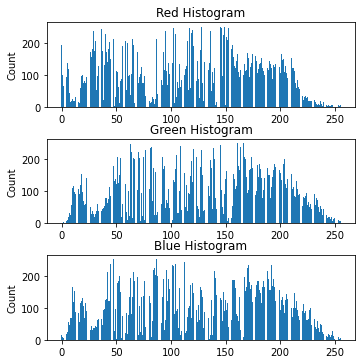

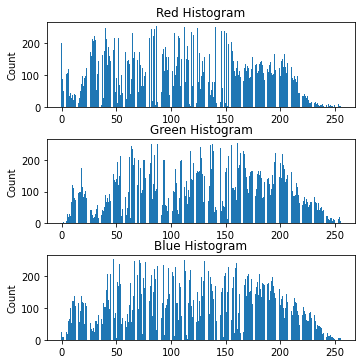

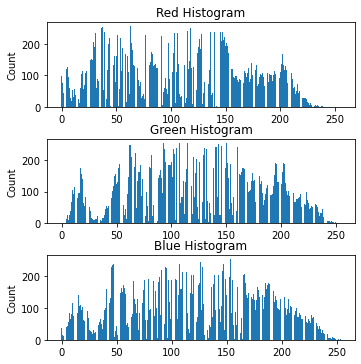

In [6]:
first_histogram = create_hist(frames[0], 'figures/histogram/first_histogram.png')
second_histogram = create_hist(frames[1], 'figures/histogram/second_histogram.png')
last_histogram = create_hist(frames[len(frames)-1], 'figures/histogram/last_histogram.png')

In [7]:
non_consecutive_intersection = hist_intersection(first_histogram, last_histogram)

Red Intersection:  19817
Green Intersection:  19125
Blue Intersection:  20032


In [8]:
consecutive_intersection = hist_intersection(first_histogram, second_histogram)

Red Intersection:  21095
Green Intersection:  23107
Blue Intersection:  23683


In [ ]:
def normalize_intersection(intersection, pixels):
    if len(intersection) == 1:
        normalized = intersection[0]/pixels
        print('Normalized intersection: ', normalized)
        return normalized
    else:
        normalized = intersection[0]/pixels, intersection[1]/pixels, intersection[2]/pixels
        print('Normalized Red Intersection: ', normalized[0])
        print('Normalized Green Intersection: ', normalized[1])
        print('Normalized Blue Intersection: ', normalized[2])
        return normalized

In [ ]:
# split image into windows
def to_windows(img):
    window_size = 3
    x, y = img.shape[0], img.shape[1]

    windows = []

    for i in range(0, x,  window_size):
        for j in range(0, y, window_size):
            window = img[i:i+window_size, j:j+window_size]
            windows.append(window)
    return windows


# apply local binary pattern
def apply_lbp(img):

    # Add border to apply for edge pixels
    img = to_grayscale(img)
#    img = add_border(img)

    x, y = img.shape[0], img.shape[1]
    new_img = np.empty((x, y, 1), dtype=np.uint8)

    for i in range(1, x-1):
        for j in range(1, y-1):

            # Compare center pixel to neighborhood
            center = img[i, j].astype(int)
            nw = 0 if center > img[i-1, j-1] else 1
            n = 0 if center > img[i-1, j] else 1
            ne = 0 if center > img[i-1, j+1] else 1
            e = 0 if center > img[i, j+1] else 1
            se = 0 if center > img[i+1, j+1] else 1
            s = 0 if center > img[i+1, j] else 1
            sw = 0 if center > img[i+1, j-1] else 1
            w = 0 if center > img[i, j-1] else 1

            # Bit code of the neighbors
            binary_string = [ne, e, se, s, sw, w, nw, n]
            decimal = 0

            # Converrt to decimal
            for k, bit in enumerate(binary_string):
                decimal += bit*(2**k)

            new_img[i, j] = decimal
    intensity, count = np.unique(new_img[:, :], return_counts=True)
    intensity, count = fill_intensities(intensity, count)
    return (count)

def get_fd(img):
    img = add_border(img)
   # img = to_grayscale(img)
    windows = to_windows(img)

    fds = []

    for window in windows:
        lbp = apply_lbp(window)
        intensity, count = np.unique(lbp, return_counts=True)
        intensity, count = fill_intensities(intensity, count)
        fds.append(count)
    return fds

def get_gd(windows):
    windows = np.array(windows)
    for i, window in enumerate(windows):
        if i==0:
            gd = window
        else:
            gd = np.concatenate((gd, window), axis=None)
    return np.array(gd, dtype=np.uint8)

In [ ]:
def get_global_descriptor(windows):
    for i, window in enumerate(windows):
        lbp = apply_lbp(window)
        if i==0:
            lbp_descriptors = lbp
        else:
            lbp_descriptors = np.concatenate((lbp_descriptors, lbp), axis=None)
    return (np.array(lbp_descriptors, dtype=np.uint8))

In [ ]:
img = cv2.imread('Dataset/DatasetA/car-3.jpg')
windows = to_windows(img)
global_descriptor = get_global_descriptor(windows)

In [ ]:
img2 = cv2.imread('Dataset/DatasetA/car-2.jpg')
windows2 = to_windows(img2)
global_descriptor2 = get_global_descriptor(windows2)
intersection1 = hist_intersection(global_descriptor, global_descriptor2)

In [ ]:
img2 = cv2.imread('Dataset/DatasetA/car-2.jpg')
windows2 = get_fd(img2)
gd = get_gd(windows2)
intersection1 = hist_intersection(global_descriptor, gd)

In [ ]:
img3 = cv2.imread('Dataset/DatasetA/car-1.jpg')
windows3 = get_fd(img3)
global_descriptor3 = get_gd(windows3)
intersection2 = hist_intersection(global_descriptor, global_descriptor3)

In [ ]:
img4 = cv2.imread('Dataset/DatasetA/face-1.jpg')
windows4 = get_fd(img4)
global_descriptor4 = get_gd(windows4)
intersection3 = hist_intersection(global_descriptor, global_descriptor4)

In [ ]:
img5 = cv2.imread('Dataset/DatasetA/face-2.jpg')
windows5 = get_fd(img5)
global_descriptor5 = get_gd(windows5)
intersection4 = hist_intersection(global_descriptor, global_descriptor5)

In [ ]:
img6 = cv2.imread('Dataset/DatasetA/face-3.jpg')
windows6 = get_fd(img6)
global_descriptor6 = get_gd(windows6)
intersection5 = hist_intersection(global_descriptor, global_descriptor6)

In [ ]:
# 5C
def get_background(frames):
    frames = np.array(frames)
    x, y, z = frames.shape[1], frames.shape[2], frames.shape[3]

    avg = np.zeros((x, y, z), dtype=np.uint8)
    
    for i in range(x):
        for j in range(y):
            avg[i, j] = np.mean(frames[:, i, j]) if z==1 else np.mean(frames[:, i, j, :])
    return avg

def get_frames(path, rbg):
    vid = cv2.VideoCapture(path)

    if (vid.isOpened()== False): 
        print("Error opening video stream or file")

    frames = []

    while(vid.isOpened()):
        ret, frame = vid.read()

        if ret==True:
            if rbg==0:
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
                frame = frame[:, :, np.newaxis]
            frames.append(frame)
        else:
            break   
    vid.release()
    cv2.destroyAllWindows()
    return frames

def play_video(frames):
    for frame in frames:
        cv2.imshow('Frame', frame)
        if cv2.waitKey(25) & 0xFF == ord('q'):
            break
    cv2.destroyAllWindows()
    pass

# 5A
def compute_segmentation(frames, reference_frame, threshold):
    frames = np.array(frames)
    
    new_frames = []
            
    for frame in frames:
        new_frame = np.abs(frame.astype('int16') - reference_frame.astype('int16'))
        new_frame[new_frame < threshold] = 0
        new_frame[new_frame > threshold] = 255
        new_frames.append(new_frame)
    new_frames = np.array(new_frames, dtype=np.uint8)
    return new_frames

# 5B
def segment_previous_frame(frames, threshold):
    frames = np.array(frames)

    new_frames = []
    for i, frame in enumerate(frames):
        if i==0:
            new_frames.append(frame)
            continue
        new_frame = np.abs(frame.astype('int16') - frames[i-1].astype('int16'))
        new_frame[new_frame < threshold] = 0
        new_frame[new_frame > threshold] = 255
        new_frames.append(new_frame)
    new_frames = np.array(new_frames, dtype=np.uint8)
    return new_frames

In [ ]:
path = 'Dataset/DatasetC.avi'

In [ ]:
frames = get_frames(path, 0)

In [ ]:
play_video(frames)

In [ ]:
reference_frame = get_background(frames)

In [ ]:
show_img(reference_frame, 'bg')

In [ ]:
segmented_frames = compute_segmentation(frames, reference_frame, 50)

In [ ]:
play_video(segmented_frames)

In [ ]:
segmented_frames2 = segment_previous_frame(frames, 20)

In [ ]:
play_video(segmented_frames2)